In [ ]:
####################################
#ENVIRONMENT SETUP

In [ ]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import xarray as xr

import sys; import os; import time; from datetime import timedelta
import pickle
import h5py
from tqdm import tqdm

In [ ]:
#MAIN DIRECTORIES
def GetDirectories():
    mainDirectory='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
    mainCodeDirectory=os.path.join(mainDirectory,"Code/CodeFiles/")
    scratchDirectory='/mnt/lustre/koa/scratch/air673/'
    codeDirectory=os.getcwd()
    return mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory

[mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory] = GetDirectories()

In [ ]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
from CLASSES_Variable_Calculation import ModelData_Class, SlurmJobArray_Class, DataManager_Class

In [ ]:
#IMPORT FUNCTIONS
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
import FUNCTIONS_Variable_Calculation
from FUNCTIONS_Variable_Calculation import *

In [ ]:
#data loading class
ModelData = ModelData_Class(mainDirectory, scratchDirectory, simulationNumber=1)
#data manager class
DataManager = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="Tracking_Algorithms", dataName="Lagrangian_UpdraftTracking",
                                dtype='float32',codeSection = "Project_Algorithms")

In [ ]:
#data manager class (for saving data)
DataManager_TrackedProfiles = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="Tracked_Profiles", dataName="Tracked_Profiles",
                                dtype='float32',codeSection = "Project_Algorithms")

In [ ]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"3_Project_Algorithms","2_Tracking_Algorithms"))
from CLASSES_TrackingAlgorithms import TrackingAlgorithms_DataLoading_Class, Results_InputOutput_Class, TrackedParcel_Loading_Class

In [ ]:
# IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"3_Project_Algorithms","3_Tracked_Profiles"))
from CLASSES_TrackedProfiles import TrackedProfiles_DataLoading_CLASS

In [ ]:
import sys
path=os.path.join(mainCodeDirectory,'Functions/')
sys.path.append(path)

import NumericalFunctions
from NumericalFunctions import * # import NumericalFunctions 
import PlottingFunctions
from PlottingFunctions import * # import PlottingFunctions

# # Get all functions in NumericalFunctions
# import inspect
# functions = [f[0] for f in inspect.getmembers(NumericalFunctions, inspect.isfunction)]
# functions

#####

#Import StatisticalFunctions 
import sys
dir2='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
path=dir2+'Functions/'
sys.path.append(path)

import StatisticalFunctions
from StatisticalFunctions import * # import NumericalFunctions 

In [ ]:
##############################################
#JOB ARRAY

In [ ]:
#JOB ARRAY SETUP
UsingJobArray=True

def GetNumJobs(res,t_res):
    if res=='1km':
        if t_res=='5min':
            num_jobs=132
        elif t_res=='1min':
            num_jobs=660
    elif res=='250m': 
        if t_res=='1min':
            num_jobs=660
    return num_jobs
num_jobs = GetNumJobs(ModelData.res,ModelData.t_res)
SlurmJobArray = SlurmJobArray_Class(total_elements=ModelData.Ntime, num_jobs=num_jobs, UsingJobArray=UsingJobArray)
start_job = SlurmJobArray.start_job; end_job = SlurmJobArray.end_job

def GetNumElements():
    loop_elements = np.arange(ModelData.Ntime)[start_job:end_job]
    return loop_elements
loop_elements = GetNumElements()

In [ ]:
##############################################
#DATA LOADING FUNCTIONS

In [ ]:
def MakeDataDictionary(variableNames,t,printstatement=False):
    timeString = ModelData.timeStrings[t]
    # print(f"Getting data from {timeString}","\n")
    
    dataDictionary = {variableName: CallLagrangianArray(ModelData, DataManager, timeString, variableName=variableName, printstatement=printstatement) 
                      for variableName in variableNames}      
    return dataDictionary
    
def GetSpatialData(t):    
    variableNames = ['Z','Y','X']
    dataDictionary = MakeDataDictionary(variableNames,t)
    [Z,Y,X] = (dataDictionary[k] for k in variableNames)
    return Z,Y,X

def GetLangrangianBinaryArray(t):
    variableNames=['PROCESSED_A_g','PROCESSED_A_c']
    binaryDictionary = MakeDataDictionary(variableNames,t)
    
    A_g = binaryDictionary['PROCESSED_A_g']
    A_c = binaryDictionary['PROCESSED_A_c']

    return A_g,A_c

In [ ]:
########################################
#RUNNING FUNCTIONS

In [ ]:
#Functions for Initializing Profile Arrays
def CopyStructure(dictionary, placeholder=None):
    """Deep-copy dictionary structure, replacing leaves with a given placeholder."""
    if isinstance(dictionary, dict):
        return {k: CopyStructure(v, placeholder) for k, v in dictionary.items()}
    else:
        return placeholder
        
def InitializeHistograms(trackedArrays, varNames, time_bins,zBins_km_g,zBins_km_c, property_bins_Dictionary):
    """
    Create a nested structure matching trackedArrays,
    with empty histogram arrays for each variable:
        - var_hist2d
        - var_parcel_last_time_hist2d
    """
    
    histogramsDictionary = {}
    n_time = len(time_bins) - 1
    
    for category, depth_dict in trackedArrays.items():  # e.g. 'CL', 'SBF'
        histogramsDictionary[category] = {}

        for depth_type in depth_dict.keys():  # e.g. 'ALL', 'SHALLOW', 'DEEP'
            histogramsDictionary[category][depth_type] = {}

            for varName in varNames:

                # ---- initialize varName level
                histogramsDictionary[category][depth_type][varName] = {}
                for mode in ["g","c"]:
                    histogramsDictionary[category][depth_type][varName][mode] = {}

                # number of property bins for this variable
                n_prop = len(property_bins_Dictionary[varName]) - 1

                # initialized z-subsetted empty histograms
                for mode, zBins in {
                    "g": zBins_km_g,
                    "c": zBins_km_c,
                }.items():
                    for z1, z2 in zBins:
                        zKey = f"{z1}_{z2}km_hist2d"
                        histogramsDictionary[category][depth_type][varName][mode][zKey] = np.zeros(
                            (n_time, n_prop)
                        )

    return histogramsDictionary

In [ ]:
def GetParcelNumbers(trackedArray, t):
    """
    Return all parcel indices (p) and their corresponding row indices
    for parcels that are active at time t.
    Vectorized, no row-by-row loops.
    """
    t_start = trackedArray[:, 1]
    t_end   = np.minimum(trackedArray[:, 2] + trackedArray[:, 3], ModelData.Ntime)

    # Boolean mask for rows active at time t
    mask = (t >= t_start) & (t <= t_end)

    # Extract parcel numbers and their corresponding row indices
    selectedRows = np.where(mask)[0]
    selectedPs = trackedArray[selectedRows, 0]
    leftRightIndexes = trackedArray[selectedRows, 4]

    return selectedRows, selectedPs, leftRightIndexes

In [ ]:
#FUNCTIONS FOR GETTING GRID BOX MATCHES

def GetGridBoxMatches_V1(Z,Y,X, zLevels,yLevels,xLevels):
    gridboxMatches = [
        np.where((Z == zLevel) & (Y == yLevel) & (X == xLevel))[0]
        for zLevel, yLevel, xLevel in zip(zLevels, yLevels, xLevels)
    ]
    if len(gridboxMatches) == 0:
        return None
    return gridboxMatches

from collections import defaultdict
def BuildGridboxIndex(Z, Y, X):
    gridIndex = defaultdict(list)
    for i in range(len(Z)):
        gridIndex[(Z[i], Y[i], X[i])].append(i)
    return gridIndex
def GetGridBoxMatches_V2(Z,Y,X, zLevels,yLevels,xLevels):
    gridIndex = BuildGridboxIndex(Z, Y, X)
    gridboxMatches = [
        np.asarray(gridIndex[(z, y, x)], dtype=int)
        for z, y, x in zip(zLevels, yLevels, xLevels)
    ]
    if len(gridboxMatches) == 0:
        return None
    return gridboxMatches


# def CheckIfSame_GridBoxMatches(one,two):
#     same = (
#         len(one) == len(two)
#         and all(
#             np.array_equal(a, b)
#             for a, b in zip(one, two)
#         )
#     )
#     print(same,"#"*10,"\n")

# gridboxMatches_original = GetGridBoxMatches_V1(Z,Y,X, zLevels,yLevels,xLevels)
# gridboxMatches = GetGridBoxMatches_V2(Z,Y,X, zLevels,yLevels,xLevels)
# CheckIfSame_GridBoxMatches(gridboxMatches_original,gridboxMatches)   

In [ ]:
#FUNCTIONS FOR APPLYING CLOUD MASK TO PARCELS

def GetEntrainmentMask(A_g,A_g_Prior,
                       A_c,A_c_Prior,
                       selectedPs):
    mask_g = (A_g & (~A_g_Prior)).astype(bool)
    mask_g[selectedPs] = False #remove the selected parcels themselves
    mask_c = (A_c & (~A_c_Prior)).astype(bool)            
    mask_c[selectedPs] = False #remove the selected parcels themselves
    return mask_g,mask_c
    
# def GetWhereOtherEntrainedParcels_V1(mask_c,gridboxMatches):
#     whereOtherEntrainedParcels_c = [idx[mask_c[idx]]
#                                     for idx in gridboxMatches]
#     if len(whereOtherEntrainedParcels_c) == 0:
#         return None
#     collapsed = np.concatenate(whereOtherEntrainedParcels_c)
#     return collapsed

def GetWhereOtherEntrainedParcels_V2(mask_c,gridboxMatches):
    collapsed = np.concatenate(gridboxMatches)
    collapsed = collapsed[mask_c[collapsed]]
    if collapsed.size == 0:
        return None
    return collapsed
    
# def CheckIfSame_WhereOtherEntrainedParcel(one,two):
#     same = np.array_equal(np.sort(one),
#                           np.sort(two))
#     print(same,"#"*10,"\n")
# collapsed_original = GetWhereOtherEntrainedParcels_V1(mask_c,gridboxMatches)
# collapsed = GetWhereOtherEntrainedParcels_V2(mask_c,gridboxMatches)
# CheckIfSame_WhereOtherEntrainedParcel(collapsed_original,collapsed)

In [ ]:
#FUNCTIONS FOR MAKING PROPERTY HISTOGRAM

def AccumulatePropertyHistogram(histogramsDictionary,
                                key1,key2,varName,
                                array,Z,
                                collapsed_g,collapsed_c,
                                relative_time,
                                property_bins_Dictionary,
                                time_bins,zBins_km_g,zBins_km_c):
    for mode, collapsed, zBins_km in (
        ("g", collapsed_g, zBins_km_g),
        ("c", collapsed_c, zBins_km_c),
    ):
        if (collapsed is None): continue

        #GETTING PROPERTY HISTOGRAMS
        ##########
        # property values at this time for these entrained parcels
        properties = array[collapsed]
        zVals_km = ModelData.zh[Z[collapsed]]
        
        # time arrays for histogram2d
        times = np.full(properties.shape, relative_time)
        # property bins for each varName
        property_bins = property_bins_Dictionary[varName]
    
        # ==========================================================
        # Make histograms
        # ==========================================================
        for z1, z2 in zBins_km:
            zMask = (zVals_km >= z1) & (zVals_km < z2)
            if not np.any(zMask):
                continue
            property_hist2d_Z, _, _ = np.histogram2d(
                times[zMask],
                properties[zMask],
                bins=(time_bins, property_bins)
            )
    
            zKey = f"{z1}_{z2}km_hist2d"
            histogramsDictionary[key1][key2][varName][mode][zKey] += property_hist2d_Z

In [ ]:
#FUNCTIONS FOR LAST ENTRAINMENT TIME COLLECTION

def InitializeLists(trackedArrays, zBins_km_g, zBins_km_c): #*LAST_DETRAINMENT
    """
    Create a nested structure matching trackedArrays,
    with empty lists for last detrainment times,
    split by updraft type (g/c) and z-bin.
    """

    lastDetrainTimesDictionary = {}

    for category, depth_dict in trackedArrays.items():  # e.g. 'CL', 'SBF'
        lastDetrainTimesDictionary[category] = {}

        for depth_type in depth_dict.keys():  # e.g. 'ALL', 'SHALLOW', 'DEEP'
            lastDetrainTimesDictionary[category][depth_type] = {}

            for mode, zBins in {
                "g": zBins_km_g,
                "c": zBins_km_c,
            }.items():

                lastDetrainTimesDictionary[category][depth_type][mode] = {}

                for z1, z2 in zBins:
                    zKey = f"{z1}_{z2}km"
                    lastDetrainTimesDictionary[category][depth_type][mode][zKey] = []
    
    return lastDetrainTimesDictionary

def UpdateLastDetrainTime(lastDetrainTimesDictionary,
                          key1,key2,
                          Z,
                          collapsed_g, collapsed_c,
                          zBins_km_g, zBins_km_c,
                          t_back, relative_time): #*LAST_DETRAINMENT

    # binary updraft membership
    A_g_now, A_c_now = GetLangrangianBinaryArray(t_back)
    A_g_prev, A_c_prev = GetLangrangianBinaryArray(t_back - 1)

    for mode, collapsed, A_prev, A_now, zBins in (
        ("g", collapsed_g, A_g_prev, A_g_now, zBins_km_g),
        ("c", collapsed_c, A_c_prev, A_c_now, zBins_km_c),
    ):
        
        if collapsed is None:
            continue
        # true detrainment event
        detrained = A_prev[collapsed] & (~A_now[collapsed])
        if not np.any(detrained):
            continue

        zVals_km = ModelData.zh[Z[collapsed]]

        for z1, z2 in zBins:
            zMask = (zVals_km >= z1) & (zVals_km < z2)
            n = np.count_nonzero(detrained & zMask)

            if n > 0:
                zKey = f"{z1}_{z2}km"
                lastDetrainTimesDictionary[key1][key2][mode][zKey].extend([int(relative_time)] * n)


In [ ]:
def MakeTrackedProfiles(trackedArrays,histogramsDictionary,lastDetrainTimesDictionary,
                        property_bins_Dictionary,varNames,
                        Z,Y,X,t, A_g,A_c,A_g_Prior,A_c_Prior,
                        zBins_km_g,zBins_km_c,
                        printstatement=True):
    """
    Update profileArraysDictionary with variable data for parcels active at time t.
    Accumulates sums and counts in both profile_array and profile_array_squares.
    """
    #CALCULATING
    for key1, subdict in trackedArrays.items():         # e.g. 'CL', 'SBF'
        print("\t",f'working on {key1}')
        for key2, trackedArray in subdict.items():           # e.g. 'ALL', 'DEEP'
            print("\t\t",f'working on {key2}')
    
            #Part 1: getting parcels in trackedArray to run through
            if printstatement: print(f"Part 1: getting parcels in trackedArray to run through")
                
            _, selectedPs, leftRightIndexes = GetParcelNumbers(trackedArray, t) #get parcels that are counted at time t
            if printstatement: print(f"\tRunning for {len(selectedPs)} Parcels")
            
            #getting Z,Y,X data
            zLevels = Z[selectedPs]; yLevels = Y[selectedPs]; xLevels = X[selectedPs]

            #Part 2: find which other parcels exist in each grid box
            if printstatement: print(f"Part 2: find which other parcels exist in each grid box")
                
            # Step a: compute spatial matches once
            if printstatement: print("\tStep a: compute spatial matches once") #SLOW POINT HERE
            gridboxMatches = GetGridBoxMatches_V2(Z,Y,X, zLevels,yLevels,xLevels)
            if gridboxMatches is None:
                continue

            #Part 3: find which of those parcels were entrained into a general/cloudy updraft
            if printstatement: print(f"Part 3: find which of those parcels were entrained into a general/cloudy updraft")
            
            # Step a: compute entrainment masks
            if printstatement: print("\tStep a: compute entrainment masks")
            mask_g,mask_c = GetEntrainmentMask(A_g,A_g_Prior,
                                               A_c,A_c_Prior,
                                               selectedPs)

            # Step b: apply masks to find all parcels
            if printstatement: print("\tStep b: apply masks to find all parcels") #SLOW POINT HERE
            collapsed_g = GetWhereOtherEntrainedParcels_V2(mask_g,gridboxMatches)
            collapsed_c = GetWhereOtherEntrainedParcels_V2(mask_c,gridboxMatches)
            if (collapsed_g is None) and (collapsed_c is None): continue

            # Step c: track parcels back (last 30 minutes) and read properties
            if printstatement: print("\tStep c: track parcels back (last 60 minutes) and read properties")

            trackTimes = np.arange(t,(t-timesteps_per_hour)-1,-1)
            for count, t_back in enumerate(tqdm(trackTimes,desc="\t\tTracking back parcels",leave=False)):
                relative_time = t_back - t

                UpdateLastDetrainTime(lastDetrainTimesDictionary,
                                      key1,key2,
                                      Z,
                                      collapsed_g, collapsed_c,
                                      zBins_km_g, zBins_km_c,
                                      t_back, relative_time) #*LAST_DETRAINMENT

                VARs = MakeDataDictionary(varNames, t_back)   
                for varName, array in VARs.items():
                    #GETTING PROPERTY HISTOGRAMS
                    AccumulatePropertyHistogram(histogramsDictionary,
                                                key1,key2,varName,
                                                array,Z,
                                                collapsed_g,collapsed_c,
                                                relative_time,
                                                property_bins_Dictionary,
                                                time_bins,zBins_km_g,zBins_km_c)
    return histogramsDictionary,lastDetrainTimesDictionary

In [ ]:
########################################
#RUNNING

In [ ]:
#Loading in Tracked Parcels Info
trackedArrays,LevelsDictionary = TrackedParcel_Loading_Class.LoadingSubsetParcelData(ModelData,DataManager,
                                                         Results_InputOutput_Class)
trackedArrays.pop("ColdPool") #removing this extra unneeded category

#needed parameters
timesteps_per_min = 1/(ModelData.time[1].item()/1e9/60 )
timesteps_per_hour = int(60*timesteps_per_min)
qcqi_thresh = 1e-6
# time_bins = np.arange(0,(0-timesteps_per_hour)-1,-1)[::-1]
time_bins = np.arange(0.5, -timesteps_per_hour-1.5, -1)[::-1]

#variables 
varNames = ["QV", "QCQI", "W", "THETA_v"]

#property bins for each variable
n_bins = 500
property_bins_Dictionary = {
    "QV":    np.linspace(0, 20/1e3, n_bins),        # water vapor mixing ratio
    "QCQI":  np.linspace(1e-6, 1e-3, n_bins),         # cloud+ice mixing ratio
    "W":     np.linspace(-5, 10, n_bins),         # vertical velocity bins
    "THETA_v":    np.linspace(300, 320, n_bins),       # potential temperature
}
zBins_km_g = [
    (0, 3),
    
    (0, 1),
    (1, 3)]
zBins_km_c = [
    (0, 7),
    
    (1, 3),
    (3, 5),
    (5, 7)]

In [ ]:
for t in tqdm(loop_elements, desc="Processing"):
    if t <= timesteps_per_hour:
        print(f"skipping time {t} since too close to first hour")
        continue
         
    print("#" * 40,"\n",f"Processing timestep {t}/{loop_elements[-1]}")
    timeString = ModelData.timeStrings[t]

    #Forming Dictionary for Profile Arrays for current timestep
    trackedProfileArrays = CopyStructure(trackedArrays)
    histogramsDictionary = InitializeHistograms(trackedProfileArrays,varNames, time_bins,zBins_km_g,zBins_km_c, property_bins_Dictionary)
    lastDetrainTimesDictionary = InitializeLists(trackedProfileArrays,zBins_km_g,zBins_km_c) #*LAST_DETRAINMENT
    
    #getting variable data
    Z,Y,X = GetSpatialData(t)
    A_g,A_c = GetLangrangianBinaryArray(t)
    A_g_Prior,A_c_Prior = GetLangrangianBinaryArray(t-1)
    
    #making tracked profiles
    print("MAKING TRACKED PROFILES")
    [histogramsDictionary,lastDetrainTimesDictionary] = MakeTrackedProfiles(trackedArrays,
                                               histogramsDictionary,lastDetrainTimesDictionary,
                                               property_bins_Dictionary,varNames,
                                               Z,Y,X,t, A_g,A_c,A_g_Prior,A_c_Prior,
                                               zBins_km_g,zBins_km_c)
    
    #saving tracked profiles for current timestep
    TrackedProfiles_DataLoading_CLASS.SaveProfile(ModelData,DataManager_TrackedProfiles, histogramsDictionary, dataName="EntrainmentTrackback", t=t)
    TrackedProfiles_DataLoading_CLASS.SaveProfile(ModelData,DataManager_TrackedProfiles, lastDetrainTimesDictionary, dataName="EntrainmentTrackback_LastDetrainmentTime", t=t)

In [ ]:
#########################################
#RECOMBINE SEPERATE JOB_ARRAYS AFTER
recombine=False #KEEP FALSE WHEN JOBARRAY IS RUNNING
# recombine=True

In [ ]:
import copy
def RecombineProfiles(ModelData, DataManager):
    """
    Combine tracked profiles across all timesteps using the first as a template.
    """
    print(f"Recombining {ModelData.Ntime} TrackedProfiles files...\n")

    histogramsDictionary_combined = None

    for t in tqdm(range(ModelData.Ntime), desc="Combining Profiles", unit="timestep"):

        if t <= timesteps_per_hour:
            print(f"skipping time {t} since too close to first hour")
            continue
        
        histogramsDictionary = TrackedProfiles_DataLoading_CLASS.LoadProfile(ModelData, DataManager, dataName="EntrainmentTrackback", t=t)
         
        # --- initialize on first timestep ---
        if histogramsDictionary_combined is None:
            histogramsDictionary_combined = copy.deepcopy(histogramsDictionary)
            continue
    
        # --- accumulate later timesteps ---
        for key1 in histogramsDictionary:
            for key2 in histogramsDictionary[key1]:
                for varName in histogramsDictionary[key1][key2]:
                    for mode in histogramsDictionary[key1][key2][varName]:
                        for zKey in histogramsDictionary[key1][key2][varName][mode]:
                            histogramsDictionary_combined[key1][key2][varName][mode][zKey] += (
                                histogramsDictionary[key1][key2][varName][mode][zKey]
                            )
    return histogramsDictionary_combined


In [ ]:
def RecombineLastDetrainmentTimes(ModelData, DataManager):
    """
    Recombine last detrainment time lists across all timesteps.
    Lists are EXTENDED (not summed).
    """

    print(f"Recombining {ModelData.Ntime} LastDetrainmentTime files...\n")

    lastDetrainTimes_combined = None

    for t in tqdm(range(ModelData.Ntime), desc="Combining LastDetrainmentTimes", unit="timestep"):

        if t <= timesteps_per_hour:
            print(f"skipping time {t} since too close to first hour")
            continue

        lastDetrainTimes = TrackedProfiles_DataLoading_CLASS.LoadProfile(
            ModelData,
            DataManager,
            dataName="EntrainmentTrackback_LastDetrainmentTime",
            t=t
        )

        # --- initialize on first valid timestep ---
        if lastDetrainTimes_combined is None:
            lastDetrainTimes_combined = copy.deepcopy(lastDetrainTimes)
            continue

        # --- extend lists for later timesteps ---
        for key1 in lastDetrainTimes:
            for key2 in lastDetrainTimes[key1]:
                for mode in lastDetrainTimes[key1][key2]:
                    for zKey in lastDetrainTimes[key1][key2][mode]:
                        lastDetrainTimes_combined[key1][key2][mode][zKey].extend(
                            lastDetrainTimes[key1][key2][mode][zKey]
                        )

    return lastDetrainTimes_combined


In [ ]:
if recombine==True:

    histogramsDictionary_combined = RecombineProfiles(ModelData, DataManager_TrackedProfiles)
    TrackedProfiles_DataLoading_CLASS.SaveProfile(ModelData,DataManager_TrackedProfiles, 
                                                  histogramsDictionary_combined, dataName="EntrainmentTrackback", t='combined')

In [ ]:
if recombine==True:
    lastDetrainTimesDictionary_combined = RecombineLastDetrainmentTimes(ModelData,DataManager_TrackedProfiles)
    TrackedProfiles_DataLoading_CLASS.SaveProfile(ModelData,DataManager_TrackedProfiles, 
                                                  lastDetrainTimesDictionary_combined, dataName="EntrainmentTrackback_LastDetrainmentTime", t='combined')

In [121]:
###################
#PLOTTING FUNCTIONS
plotting=False
# plotting=True

In [122]:
#Loading Back In
if plotting:
    histogramsDictionary_combined = TrackedProfiles_DataLoading_CLASS.LoadProfile(ModelData,DataManager_TrackedProfiles, dataName="EntrainmentTrackback", t='combined')
    
    lastDetrainTimesDictionary_combined = TrackedProfiles_DataLoading_CLASS.LoadProfile(ModelData,DataManager_TrackedProfiles, dataName="EntrainmentTrackback_LastDetrainmentTime", t='combined')

In [123]:
def NormalizeHistogram(histogram):
    histogram_sum = histogram.sum(axis=1, keepdims=True)
    histogram_normalized = np.divide(histogram,histogram_sum, 
                          out=np.zeros_like(histogram, dtype=float),
                          where=histogram_sum != 0)
    return histogram_normalized

In [124]:
def CombinedPlot_PropertyHistogram_V1(parcelType,mode,zKey,
                                      plotType="contour",normalize = True):
    mins=ModelData.time[1].item()/1e9/60
    
    varNames     = ["QV", "QCQI", "W", "THETA_v"]
    parcelDepths = ["ALL", "SHALLOW", "DEEP"]

    nrows = len(parcelDepths)
    ncols = len(varNames)

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(4.5 * ncols, 3.5 * nrows),
        constrained_layout=True
    )

    for i, parcelDepth in enumerate(parcelDepths):
        for j, varName in enumerate(varNames):

            ax = axes[i, j]

            a = histogramsDictionary_combined[parcelType][parcelDepth][varName][mode][zKey]

            if normalize:
                a = NormalizeHistogram(a)
                a *= 100
                colorbarTitle = "Frequency (%)" if j == ncols - 1 else ""
            else:
                colorbarTitle = "Count" if j == ncols - 1 else ""

            x = mins * time_bins
            y = property_bins_Dictionary[varName]

            x_centers = 0.5 * (x[:-1] + x[1:])
            y_centers = 0.5 * (y[:-1] + y[1:])
            X, Y = np.meshgrid(x_centers, y_centers)

            multiplier = 1e3 if varName in ["QV", "QCQI"] else 1

            if plotType == "contour":
                plotObject = ax.contourf(
                    X,
                    multiplier * Y,
                    a.T,
                    cmap="turbo",
                    levels=20
                )
            else:
                plotObject = ax.pcolormesh(
                    x,
                    multiplier * y,
                    a.T,
                    cmap="turbo",
                    shading="auto"
                )

            # ---- labels ----
            if i == nrows - 1:
                ax.set_xlabel("Backwards Time (mins)")
            if j == 0:
                ax.set_ylabel(f"{parcelDepth}\n{varName}")
            else:
                ax.set_ylabel(varName)

            ax.set_title(varName if i == 0 else "")

            plt.colorbar(plotObject, ax=ax, label=colorbarTitle)

    plt.suptitle(
        f"Parcel History Histograms ({parcelType}) ({zKey.replace('_', '-', 1).split("_")[0]})",
        fontsize=16
    )

    return fig

In [125]:
def GetPlottingDirectory(plotFileName, plotType):
    plottingDirectory = mainCodeDirectory=os.path.join(mainDirectory,"Code","PLOTTING")
    
    specificPlottingDirectory = os.path.join(plottingDirectory, plotType, 
                                             f"{ModelData.res}_{ModelData.t_res}_{ModelData.Nz_str}nz")
    os.makedirs(specificPlottingDirectory, exist_ok=True)

    plottingFileName=os.path.join(specificPlottingDirectory, plotFileName)

    return plottingFileName
    
def SaveFigure(fig,fileName,
               plotType=f"Project_Algorithms/Tracked_Profiles/Tracked_Profiles_EntrainmentTrackback"):
    plotFileName = f"{fileName}_{ModelData.res}_{ModelData.t_res}_{ModelData.Np_str}.jpg"
    plottingFileName = GetPlottingDirectory(plotFileName, plotType)
    
    print(f"Saving figure to {plottingFileName}")
    fig.savefig(plottingFileName, dpi=300, bbox_inches='tight')
    plt.close(fig) 

In [126]:
###################
#PLOTTING

In [ ]:
if plotting:
    parcelTypes = ["CL","nonCL","SBF"]
    for parcelType in tqdm(parcelTypes):
        for mode, zBins_km in (
                ("g", zBins_km_g),
                ("c", zBins_km_c)):
            
            for z1, z2 in zBins_km:
                zKey = f"{z1}_{z2}km_hist2d"
                fig = CombinedPlot_PropertyHistogram_V1(parcelType,mode,zKey)
                fileName = f"EntrainmentTrackback_PropertyHistogram_{parcelType}_{mode}_{zKey}"
                SaveFigure(fig,fileName)

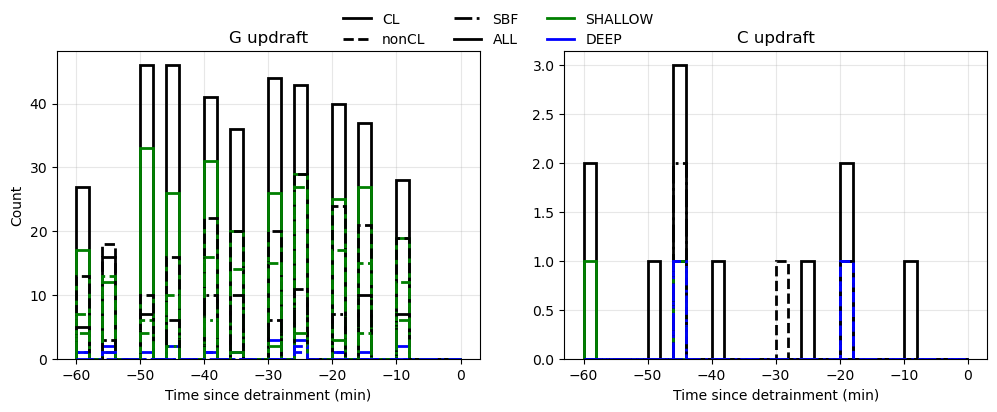

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --------------------------------------------------
# settings
# --------------------------------------------------
bins = np.arange(-60, 1, 2)

categoryStyles = {
    "CL": "-",
    "nonCL": "--",
    "SBF": "-.",
}

depthColors = {
    "ALL": "black",
    "SHALLOW": "green",
    "DEEP": "blue",
}

modes = ["g", "c"]

# convert to minutes
mins = ModelData.time[1].item() / 1e9 / 60

# --------------------------------------------------
# figure
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, mode in zip(axes, modes):

    # >>> NEW <<< choose z-bin by mode
    zKey = "0_3km" if mode == "g" else "0_7km"

    for category, linestyle in categoryStyles.items():
        for depth, color in depthColors.items():

            times = lastDetrainTimesDictionary_combined[category][depth][mode][zKey]
            if len(times) == 0:
                continue

            timesMin = mins * np.array(times)

            ax.hist(
                timesMin,
                bins=bins,
                histtype="step",
                linestyle=linestyle,
                linewidth=2,
                color=color,
            )

    ax.set_title(f"{mode.upper()} updraft")
    ax.set_xlabel("Time since detrainment (min)")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Count")

# --------------------------------------------------
# legend (manual, clean)
# --------------------------------------------------
legendLines = [
    Line2D([0], [0], color="black", lw=2, linestyle="-", label="CL"),
    Line2D([0], [0], color="black", lw=2, linestyle="--", label="nonCL"),
    Line2D([0], [0], color="black", lw=2, linestyle="-.", label="SBF"),
    Line2D([0], [0], color="black", lw=2, linestyle="-", label="ALL"),
    Line2D([0], [0], color="green", lw=2, linestyle="-", label="SHALLOW"),
    Line2D([0], [0], color="blue", lw=2, linestyle="-", label="DEEP"),
]

fig.legend(
    handles=legendLines,
    loc="upper center",
    ncol=3,
    frameon=False,
)

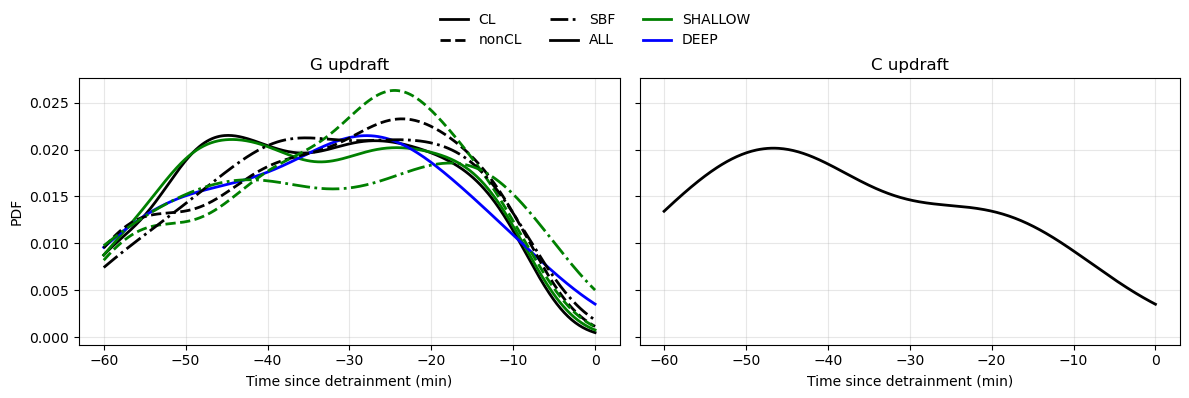

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

# --------------------------------------------------
# settings
# --------------------------------------------------
xGrid = np.linspace(-60, 0, 400)

categoryStyles = {
    "CL": "-",
    "nonCL": "--",
    "SBF": "-.",
}

depthColors = {
    "ALL": "black",
    "SHALLOW": "green",
    "DEEP": "blue",
}

modes = ["g", "c"]

mins = ModelData.time[1].item() / 1e9 / 60

# --------------------------------------------------
# figure
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for ax, mode in zip(axes, modes):

    zKey = "0_3km" if mode == "g" else "0_7km"

    for category, linestyle in categoryStyles.items():
        for depth, color in depthColors.items():

            times = lastDetrainTimesDictionary_combined[category][depth][mode][zKey]
            if len(times) < 5:
                continue  # KDE needs a few samples

            timesMin = mins * np.array(times)

            kde = gaussian_kde(timesMin)
            pdf = kde(xGrid)

            ax.plot(
                xGrid,
                pdf,
                linestyle=linestyle,
                linewidth=2,
                color=color,
            )

    ax.set_title(f"{mode.upper()} updraft")
    ax.set_xlabel("Time since detrainment (min)")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("PDF")

# --------------------------------------------------
# legend
# --------------------------------------------------
legendLines = [
    Line2D([0], [0], color="black", lw=2, linestyle="-", label="CL"),
    Line2D([0], [0], color="black", lw=2, linestyle="--", label="nonCL"),
    Line2D([0], [0], color="black", lw=2, linestyle="-.", label="SBF"),
    Line2D([0], [0], color="black", lw=2, linestyle="-", label="ALL"),
    Line2D([0], [0], color="green", lw=2, linestyle="-", label="SHALLOW"),
    Line2D([0], [0], color="blue", lw=2, linestyle="-", label="DEEP"),
]

fig.legend(
    handles=legendLines,
    loc="upper center",
    ncol=3,
    frameon=False,
)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()
